# Unstructured Data Analysis-Final Project: Harry Potter and Friends (?)
## Exploratory Data Analysis and Knowledge Graphs


### Table of Contents
1. [Initial Exploratory Data Analysis](#initialeda)
1. [Bigrams Graph Visualization](#bigrams)
1. [Knowledge Graph with Spacy](#kg)

In [1]:
# load packages
import time
start_time = time.time()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


# text analysis
from collections import Counter
from collections import defaultdict

# sklearn package
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

# text analysis nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords 

# sentiment analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# community detection
from community import community_louvain

# graphs
from PIL import Image 
import networkx as nx 
from pylab import *

from eda_utils import *


# spacy library
import spacy
import textacy
from spacy import displacy


from tqdm import tqdm


from kg_utils import *

In [2]:
#set seed
np.random.seed(30224)

In [3]:
# further it is recommended to download at this stage

#!python -m spacy download en_core_web_sm

### 1. Initial Exploratory Data Analysis <a class="anchor" id="initialeda"></a>
### 1.1 Initial Data Preprocessing  <a class="anchor" id="initialeda"></a>

FOr data preprocessing we use the functions clean_df() and create_sentence() and  get_sentence_df() from eda_utils.py.

In [4]:
#create dataframe from book files
get_books=[] 

for i in range(1,8): 
    get_books.append('HPBook'+str(i)+'.txt')
    book_path= "./data/{}".format(get_books[i-1])
    if i == 1: # first book "Philosopher Stone"
        df = pd.read_csv(book_path, sep="@")
    else: 
        df_2_7 = pd.read_csv(book_path, sep="@")
        df = pd.concat([df, df_2_7])

In [5]:
# download punctuation and stopwords
#nltk.download('punkt')
#nltk.download('stopwords')

In [6]:
# create dataframe with cleaned columns and tokenized words
stopwords = set(stopwords.words('english'))
df = clean_df(df, stopwords)
df.head(3)

,Text,Chapter,Book,words,counts,clean_words,clean_words_gender,words_remove_harry
0,"THE BOY WHO LIVED Mr. and Mrs. Dursley, of nu...",1,1,"[the, boy, who, lived, mr, and, mrs, dursley, ...",4591,"[boy, lived, mr, mrs, dursley, number, four, p...","[boy, lived, mr, mrs, dursley, number, four, p...","[boy, lived, mr, mrs, dursley, number, four, p..."
1,THE VANISHING GLASS Nearly ten years had pass...,2,1,"[the, vanishing, glass, nearly, ten, years, ha...",3445,"[vanishing, glass, nearly, ten, years, passed,...","[vanishing, glass, nearly, ten, years, passed,...","[vanishing, glass, nearly, ten, years, passed,..."
2,THE LETTERS FROM NO ONE The escape of the Bra...,3,1,"[the, letters, from, no, one, the, escape, of,...",3842,"[letters, one, escape, brazilian, boa, constri...","[letters, one, escape, brazilian, boa, constri...","[letters, one, escape, brazilian, boa, constri..."


In [7]:
for i in range(1,8,1):
    book_i = df[df['Book']== i]
    chapter_number = book_i['Chapter'].max()
    print(f'The number of chapter of book {i} is: {chapter_number}')
    counts_longest_chapter = book_i['counts'].max()
    print(f'The longest chapter of book {i} has {counts_longest_chapter} word counts.')

The number of chapter of book 1 is: 17
The longest chapter of book 1 has 6570 word counts.
The number of chapter of book 2 is: 19
The longest chapter of book 2 has 8528 word counts.
The number of chapter of book 3 is: 22
The longest chapter of book 3 has 7237 word counts.
The number of chapter of book 4 is: 37
The longest chapter of book 4 has 8177 word counts.
The number of chapter of book 5 is: 38
The longest chapter of book 5 has 8928 word counts.
The number of chapter of book 6 is: 30
The longest chapter of book 6 has 7045 word counts.
The number of chapter of book 7 is: 37
The longest chapter of book 7 has 7930 word counts.


HP 5 has the highest number of chapters, 38 and the longeset chapter with 8928 words.

In [8]:
# create dataframe with tokenized and cleaned sentence
sentence_df = create_sentence(df)
sentence_df = get_sentence_df(sentence_df)
sentence_df.head(3)

,Book,Chapter,sentence
0,1,1,the boy who lived mr and mrs dursley of numbe...
1,1,1,they were the last people youd expect to be in...
2,1,1,mr dursley was the director of a firm called g...


### 1.2 Word Counts and Word Counts <a class="anchor" id="initialeda"></a>

In [9]:
# get most occurent clean words from data
all_clean_words = df['clean_words'].to_list()
all_clean_words = np.concatenate(all_clean_words)
count_dict = Counter(all_clean_words)
print(f'Unique words in book series: {len(count_dict.keys())}')
all_clean_words_count = pd.DataFrame(count_dict.items()).rename(columns={0:'word',1:'count'})
all_clean_words_count = all_clean_words_count.sort_values(by = 'count', ascending=False)
all_clean_words_count.head(5)

Unique words in book series: 31179


,word,count
320,harry,15979
185,said,14366
3140,ron,5579
3363,hermione,4759
180,back,3168


In [10]:
# occurence of main characters
main_characters = ["harry", "ron", "hermione"]
main_characters_count = all_clean_words_count[all_clean_words_count["word"].isin(main_characters)]
main_characters_count["count"].head()

320     15979
3140     5579
3363     4759
Name: count, dtype: int64

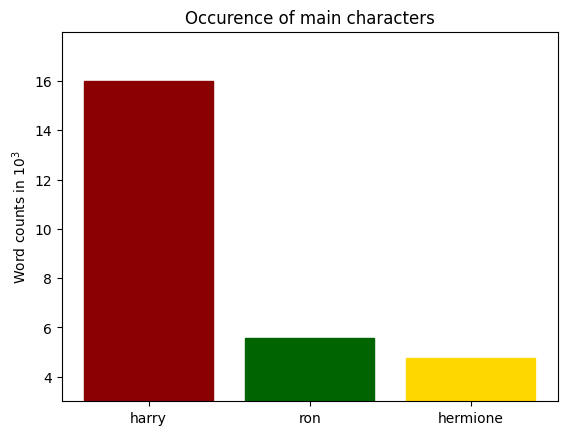

In [11]:
main_characters = ["harry", "ron", "hermione"]
bar = plt.bar(main_characters, height=[15979, 5579, 4759],color = "skyblue")
bar[0].set_color('darkred')
bar[1].set_color('darkgreen')
bar[2].set_color('gold')
plt.xticks( ["harry", "ron", "hermione"])
plt.ylim(3000, 18000)
plt.yticks(ticks=[4000, 6000, 8000, 10000, 12000, 14000, 16000], labels=[4,6,8,10,12,14,16])
plt.ylabel('Word counts in $10^3$')
plt.title('Occurence of main characters')
plt.savefig('./images/eda/hist_main_characters.png')

It is obvious that as expected the main characters harry, ron, hermione appears most frequently. Now we want to create wordclouds with the function getWordCloud() from eda_utils.py.

In [12]:
# word clouds with cleaned words
unique_counts = []
for i in range(1,8,1):
    book_i = df[df['Book'] == i]
    words = book_i['clean_words'].to_list()
    words = np.concatenate(words)
    count_dict = Counter(words)
    print(f'Unique words in book {i}: {len(count_dict.keys())}')
    unique_counts.append(len(count_dict.keys()))
    data = pd.DataFrame(count_dict.items()).rename(columns={0:'word',1:'count'})
    title = f'Harry Potter Book {i}'
    color = 'Blues'
    word_cloud = get_WordCloud(data, color)
    # plot image of wordcloud
    plt.figure(figsize = (7,5))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title(title, fontsize=12)
    # remove axis for better visualization
    plt.axis('off')
    plt.savefig(f'./images/eda/HP_Wordclouds {i}.png')
    plt.close()


Unique words in book 1: 5871
Unique words in book 2: 7205
Unique words in book 3: 7582
Unique words in book 4: 10621
Unique words in book 5: 13133
Unique words in book 6: 12433
Unique words in book 7: 16661


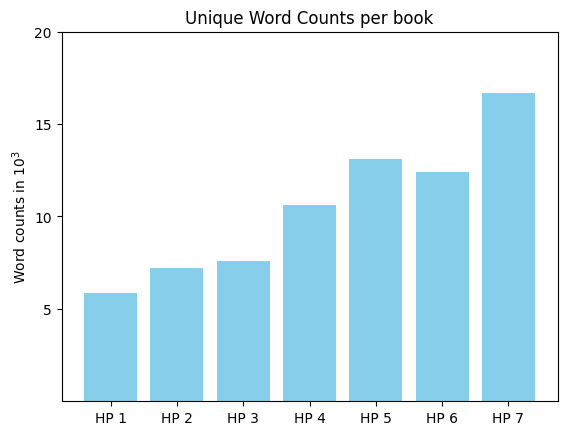

In [13]:
# book counts of cleaned words
book_counts = df.groupby(['Book'])['counts'].agg('sum').reset_index()
book_counts
plt.bar(book_counts['Book'], height=pd.Series(unique_counts),color = "skyblue")
plt.xticks(book_counts['Book'], ['HP 1','HP 2','HP 3', 'HP 4', 'HP 5', 'HP 6', 'HP 7'])
plt.yticks(ticks=[5000, 10000, 15000, 20000], labels=[5,10,15,20])
plt.ylabel('Word counts in $10^3$')
plt.title('Unique Word Counts per book')
plt.savefig('./images/eda/hist_wordcounts_cleaned.png')

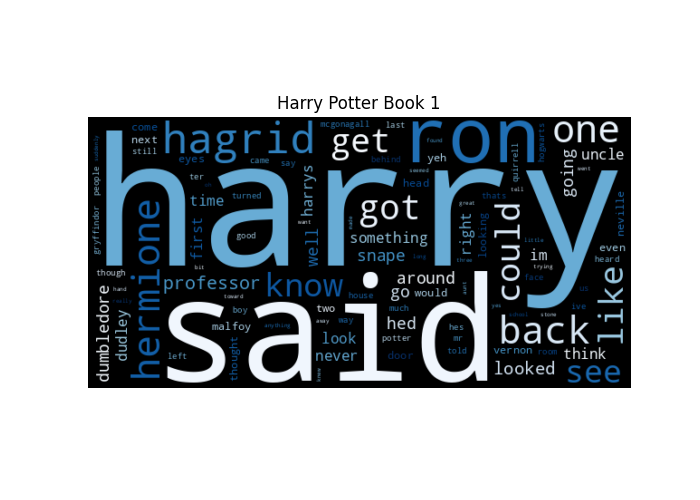

In [14]:
# wordcloud of HP1
from IPython.display import display, Image
display(Image(filename="./images/eda/HP_Wordclouds 1.png"))

In [15]:
# wordclouds after removing harry, said
for i in range(1,8,1):
    book_i = df[df['Book'] == i]
    words = book_i['words_remove_harry'].to_list()
    words = np.concatenate(words)
    count_dict = Counter(words)
    data = pd.DataFrame(count_dict.items()).rename(columns={0:'word',1:'count'})
    title = f'Harry Potter Book {i}'
    color = 'Blues'
    word_cloud = get_WordCloud(data, color)
    # plot image of wordcloud
    plt.figure(figsize = (7,5))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title(title, fontsize=12)
    # remove axis for better visualization
    plt.axis('off')
    plt.savefig(f'./images/eda/HP_Wordclouds_Opt {i}.png')
    plt.close()

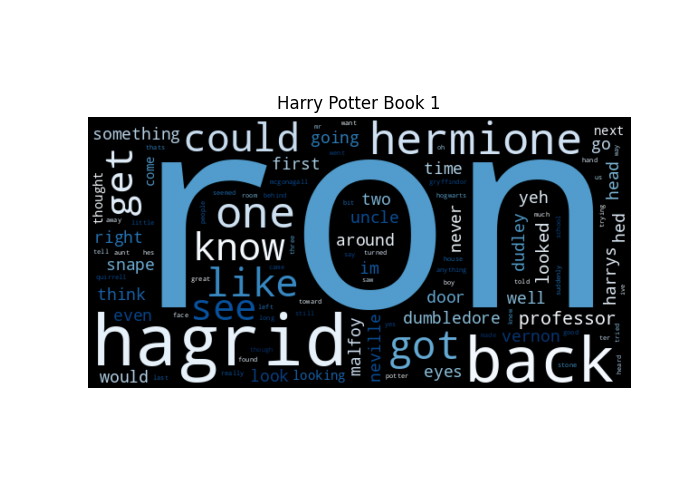

In [16]:
# wordcloud (optimized of HP 1)
display(Image(filename="./images/eda/HP_Wordclouds_Opt 1.png"))

In [17]:
# get the number of unique cleaned words
clean_words = df['clean_words'].to_list()
clean_words = np.concatenate(clean_words)
count_dict = Counter(clean_words)

print(f' The number of all unique cleaned words in the book series are {len(count_dict.keys())}.')

 The number of all unique cleaned words in the book series are 31179.


### 1.2 Unigram Analysis with Zipfs Law <a class="anchor" id="initialeda"></a>

In this part we will analyse the language and rank of all words, which os used in the novels.

In [18]:
# book analysis
book_counts = df.groupby(['Book'])['counts'].agg('sum').reset_index()
book_counts

,Book,counts
0,1,77575
1,2,84971
2,3,104877
3,4,190830
4,5,257170
5,6,169306
6,7,192239


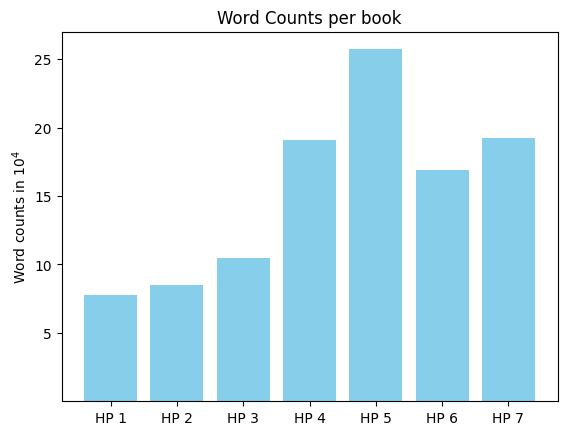

In [19]:
# word counts of all books
plt.bar(book_counts['Book'], height=book_counts['counts'],color = "skyblue")
plt.xticks(book_counts['Book'], ['HP 1','HP 2','HP 3', 'HP 4', 'HP 5', 'HP 6', 'HP 7'])
plt.yticks(ticks=[50000, 100000, 150000, 200000, 250000], labels=[5,10,15,20,25])
plt.ylabel('Word counts in $10^4$')
plt.title('Word Counts per book')
plt.savefig('./images/eda/hist_wordcounts_uncleaned.png')

In [20]:
# list of unigrams (uncleaned words)
unigrams = df['words'].to_list()
unigrams = np.concatenate(unigrams)
count_dict_unigrams = Counter(unigrams)

print(f' The number of all unique words in the book series are {len(count_dict_unigrams.keys())}.')

 The number of all unique words in the book series are 31354.


In [21]:
unigrams_df = pd.DataFrame(count_dict_unigrams.items()).rename(columns={0:'unigrams',1:'count'})
unigrams_df = unigrams_df.sort_values(by='count', ascending=False)

In [22]:
unigrams_df.head()

,unigrams,count
0,the,51275
5,and,27129
15,to,26910
8,of,21701
45,a,20887


It must be noted that this part is inspire by:
https://github.com/tthustla/twitter_sentiment_analysis_part3/blob/master/Capstone_part3-Copy2.ipynb

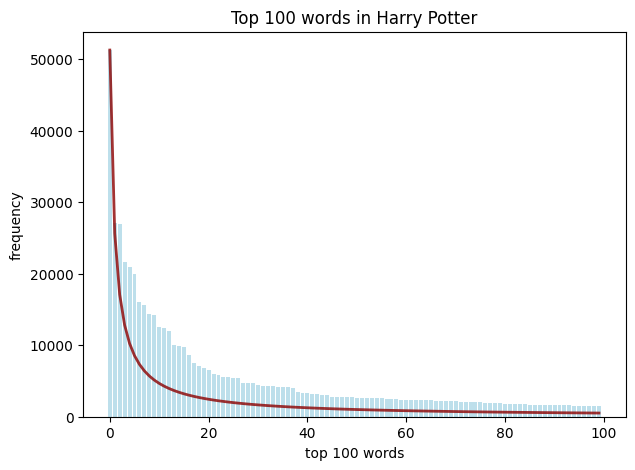

In [23]:
# get histgram for testing Zipf's law
top_100 = np.arange(100)
plt.figure(figsize=(7,5))
sort_unigrams = unigrams_df.sort_values(by='count', ascending=False)
zipf_expect = [sort_unigrams['count'][0]/(i+1) for i in top_100]
unigrams_top_100 = unigrams_df.sort_values(by='count', ascending=False)['count'][:100]
plt.bar(top_100, unigrams_top_100, align='center', alpha=0.8, color = 'lightblue')
plt.plot(top_100, zipf_expect, color='darkred', linestyle='-',linewidth=2,alpha=0.8)
plt.ylabel('frequency')
plt.xlabel('top 100 words')
plt.title('Top 100 words in Harry Potter')
plt.savefig('./images/eda/zipf_histogram.png')

In [24]:
# get counts of top stopwords (uncleaned words)
unigrams_df.index = unigrams_df['unigrams']
unigrams_df = unigrams_df.drop('unigrams', axis=1)
unigrams_df.head(5)

,count
unigrams,
the,51275
and,27129
to,26910
of,21701
a,20887


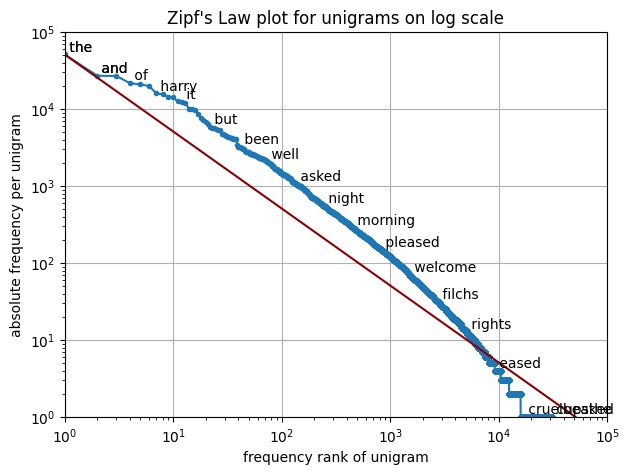

In [25]:
# this part is as well inspired by https://github.com/tthustla/twitter_sentiment_analysis_part3/blob/master/Capstone_part3-Copy2.ipynb


count_unigrams = unigrams_df['count']
tokens = unigrams_df.index
ranks = arange(1, len(count_unigrams)+1)
indices = argsort(-count_unigrams)
plt.figure(figsize=(7,5))
plt.ylim(1,10**5)
plt.xlim(1,10**5)
loglog(ranks, count_unigrams[indices], marker=".")
plt.plot([1,count_unigrams[indices][0]],[count_unigrams[indices][0],1],color='darkred')
plt.title("Zipf's Law plot for unigrams on log scale")
plt.xlabel("frequency rank of unigram")
plt.ylabel("absolute frequency per unigram")
plt.grid(True)
for n in list(logspace(-0.5, log10(len(count_unigrams)-2), 20).astype(int)):
    dummy = text(ranks[n], count_unigrams[indices][n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")
plt.savefig('./images/eda/zipf_linear.png')

## 2. Bigrams Graph Visualization <a class="anchor" id="bigrams"></a>

In [26]:
# get bigrams
bigrams = list(ngrams(clean_words, 2))
# use FreqDist
bigram_freq = nltk.FreqDist(bigrams)
count_dict = Counter(bigrams)
bigram_freq.most_common(10)

[(('said', 'harry'), 2622),
 (('said', 'ron'), 1526),
 (('said', 'hermione'), 1242),
 (('ron', 'hermione'), 734),
 (('harry', 'said'), 677),
 (('said', 'dumbledore'), 664),
 (('harry', 'ron'), 640),
 (('professor', 'mcgonagall'), 572),
 (('mrs', 'weasley'), 566),
 (('mr', 'weasley'), 540)]

In [27]:
# create dataframe of bigram counts
bigrams_df = pd.DataFrame(count_dict.items()).rename(columns={0:'bigrams',1:'count'})
bigrams_df = bigrams_df.sort_values(by='count', ascending=False)
bigrams_g = pd.DataFrame(bigrams_df['bigrams'].tolist(), columns=["word1", "word2"])
bigrams_g['count'] = pd.Series(np.array(bigrams_df['count']))
bigrams_g.head()

,word1,word2,count
0,said,harry,2622
1,said,ron,1526
2,said,hermione,1242
3,ron,hermione,734
4,harry,said,677


In [28]:
# create directed bigrams graph
G_bigrams = nx.from_pandas_edgelist(bigrams_g[:50], source = "word1", target = "word2", edge_attr = "count", create_using = nx.DiGraph())

It is useful to analyse the graph with the typical methods: degree centrality, page rank, betweenness centrality.

In [29]:
# degree centrality
deg_cent = nx.degree_centrality(G_bigrams)
deg_cent = pd.DataFrame(deg_cent.items(), columns=['word', 'deg_cent'])
deg_cent = deg_cent.sort_values(by='deg_cent', ascending=False).reset_index().drop('index', axis = 1)
deg_cent.head()

,word,deg_cent
0,said,0.40
1,harry,0.24
2,professor,0.08
3,ron,0.08
4,hermione,0.08


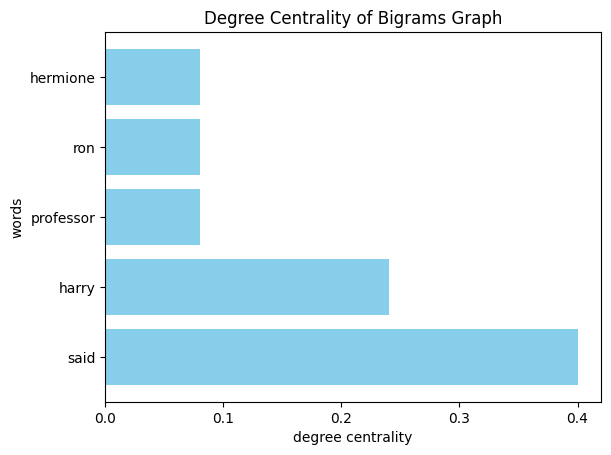

In [30]:
plt.barh(deg_cent['word'][:5], deg_cent['deg_cent'][:5],color = "skyblue")
plt.xticks(ticks=[0, 0.1, 0.2, 0.3, 0.4])
plt.ylabel('words')
plt.xlabel('degree centrality')
plt.title('Degree Centrality of Bigrams Graph')
plt.savefig('./images/eda/bigrams_deg_cent.png')

In [31]:
bet_cent = nx.betweenness_centrality(G_bigrams)
bet_cent = pd.DataFrame(bet_cent.items(), columns=['word', 'bet_cent'])
bet_cent = bet_cent.sort_values(by='bet_cent', ascending=False)
bet_cent.head()

,word,bet_cent
0,said,0.075510
1,harry,0.034286
5,professor,0.009796
10,could,0.006531
19,looked,0.006531


In [32]:
in_deg_cent = nx.in_degree_centrality(G_bigrams)
in_deg_cent = pd.DataFrame(in_deg_cent.items(), columns=['word', 'in_deg_cent'])
in_deg_cent = in_deg_cent.sort_values(by='in_deg_cent', ascending=False)
in_deg_cent.head()

,word,in_deg_cent
0,said,0.14
3,hermione,0.06
2,ron,0.04
17,george,0.04
8,weasley,0.04


In [33]:
page_rank = nx.pagerank(G_bigrams)
page_rank = pd.DataFrame(page_rank .items(), columns=['word', 'page_rank'])
page_rank = page_rank.sort_values(by='page_rank', ascending=False)
page_rank.head()

,word,page_rank
0,said,0.089287
8,weasley,0.043910
17,george,0.034087
29,got,0.033986
3,hermione,0.028285


In [34]:
# create undirected bigrams graph for better visualization
G_bigrams = nx.from_pandas_edgelist(bigrams_g[:50], source = "word1", target = "word2", edge_attr = "count", create_using = nx.Graph())

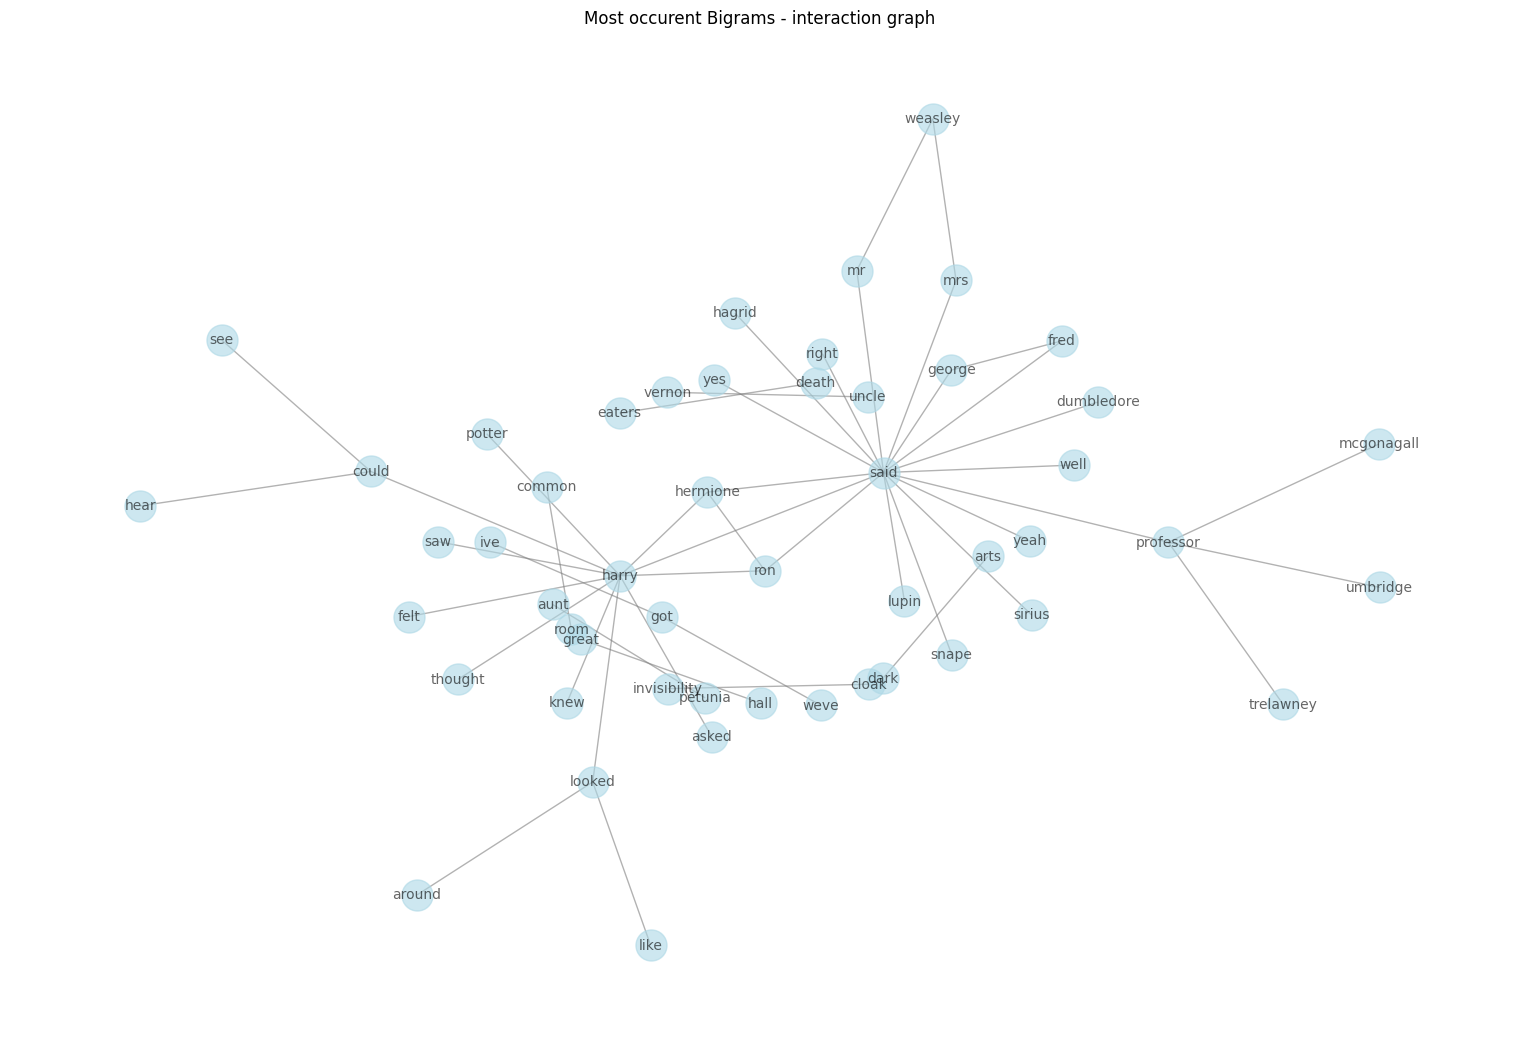

In [35]:
# plot graph 
plt.figure(figsize = (15,10))
pos = nx.kamada_kawai_layout(G_bigrams, scale = 1)
nx.draw(G_bigrams,  pos, with_labels=True, font_size=10, node_size=500, node_color='lightblue', edge_color='gray', alpha=0.6)
plt.title('Most occurent Bigrams - interaction graph')
plt.show()

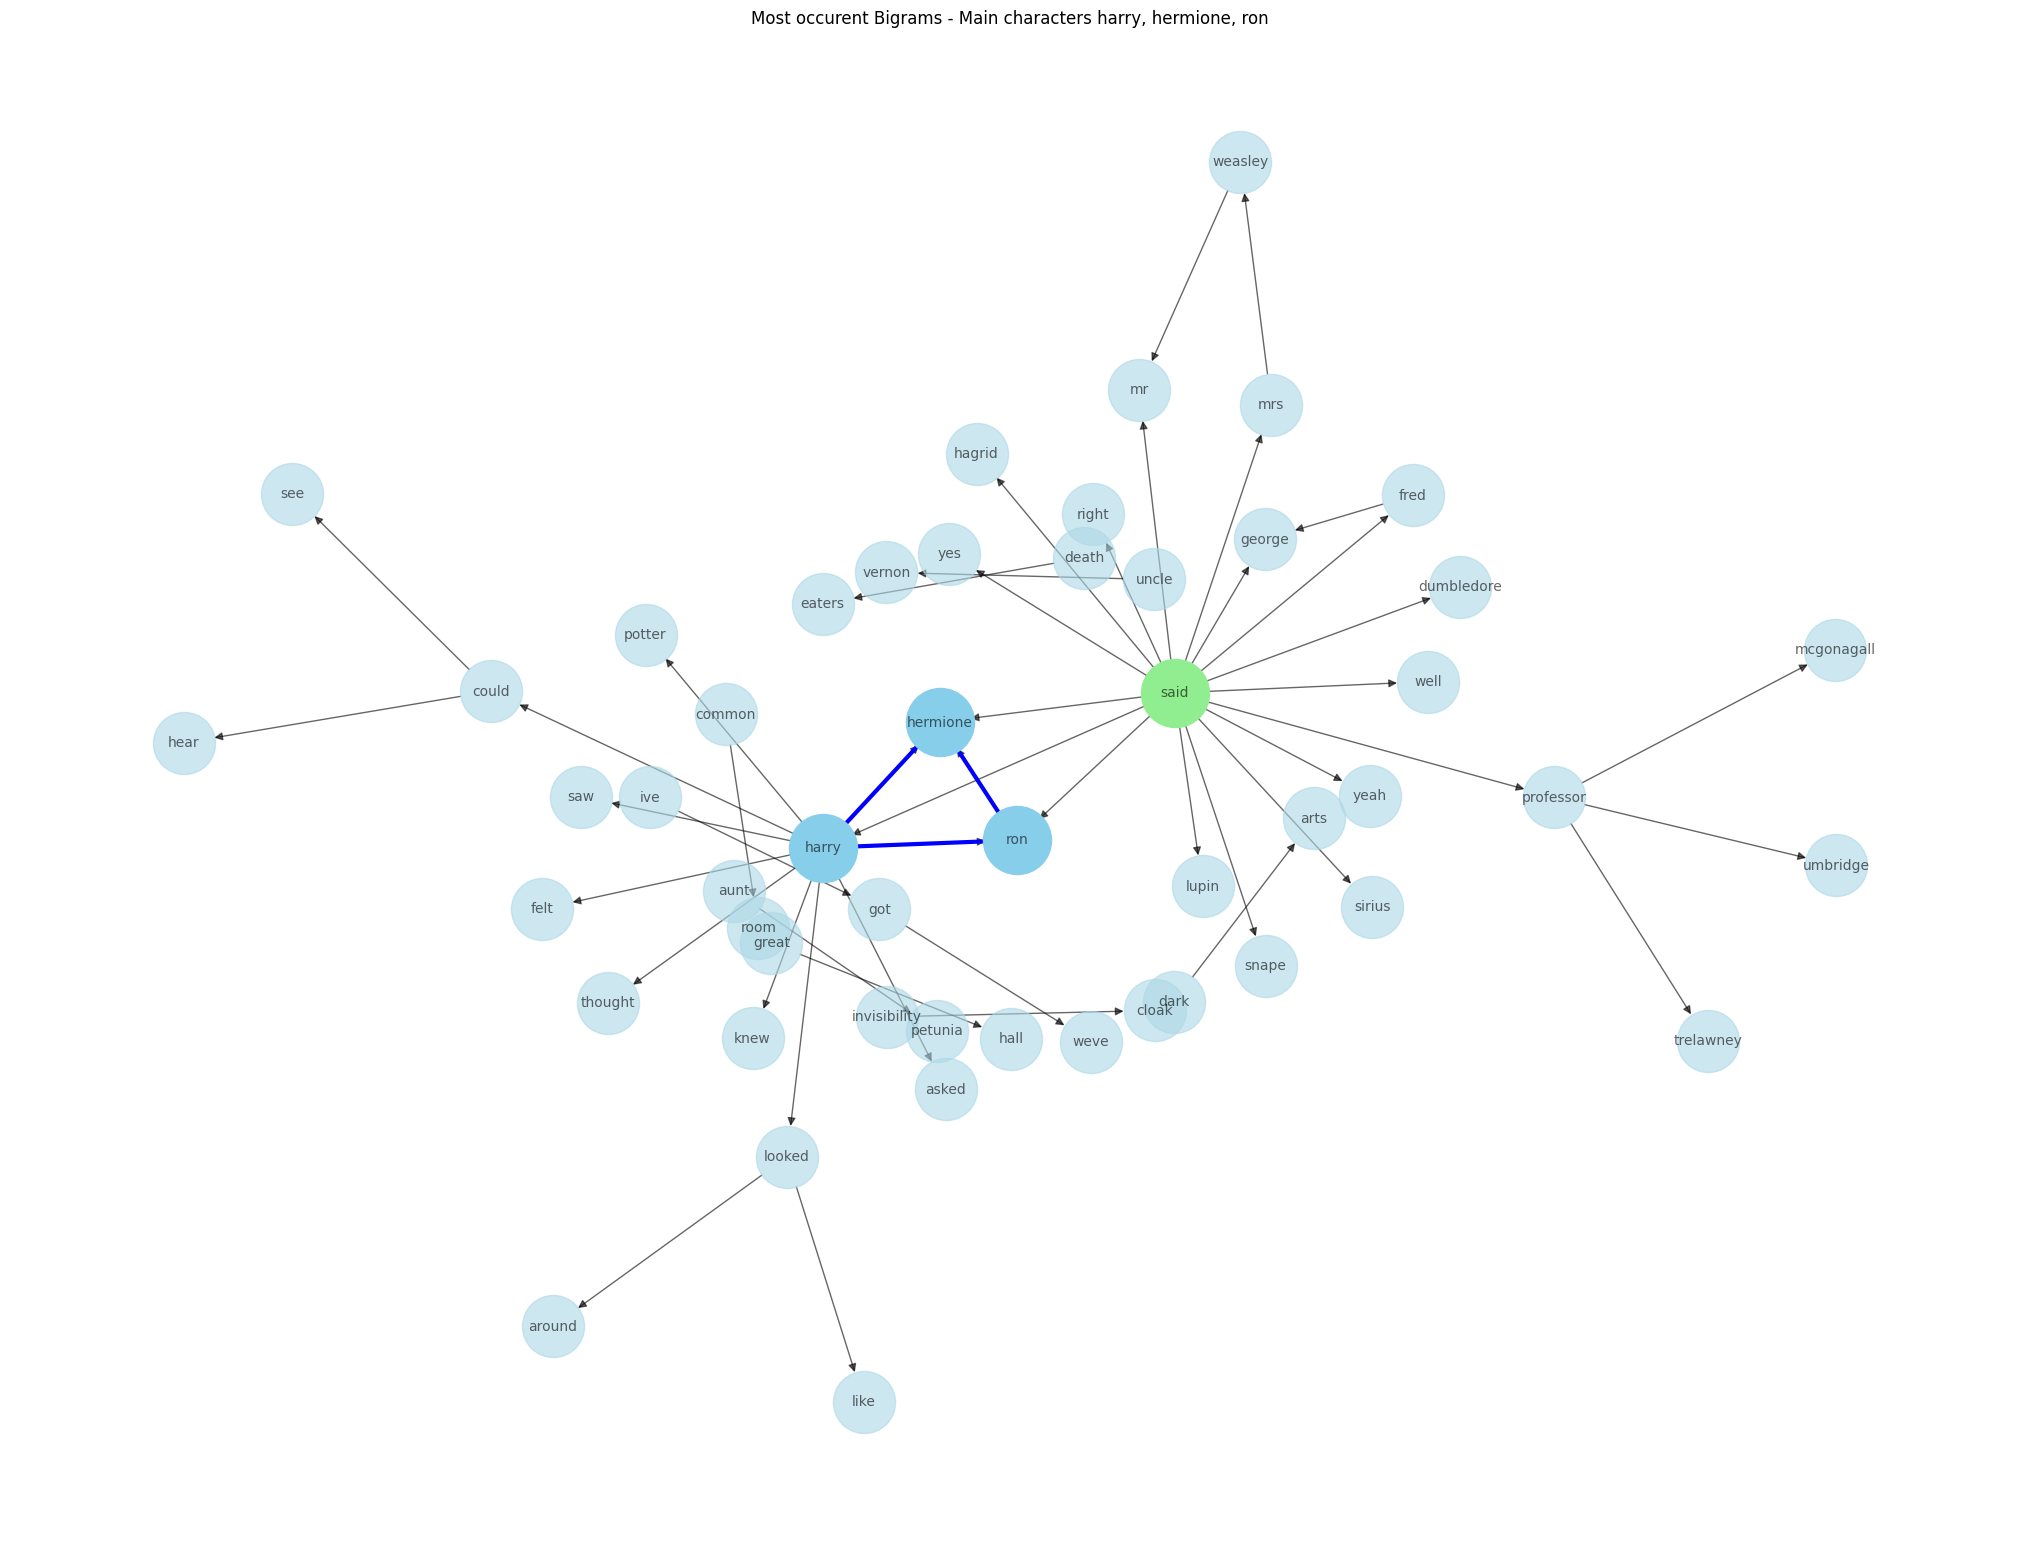

In [36]:
# adjust the code for clearer interpretation of the results by considering the graph above

source_node = 'harry'
target_node_1 = 'hermione'
target_node_2 = 'ron'

main_characters = ['harry', 'hermione','ron']
direct_speech = ['said']


# Find the shortest path
shortest_path_1 = nx.shortest_path(G_bigrams, source=source_node, target=target_node_1)
shortest_path_2 = nx.shortest_path(G_bigrams, source=source_node, target=target_node_2)
shortest_path_3 = nx.shortest_path(G_bigrams, source=target_node_1, target=target_node_2)
options = {'arrowstyle': '-|>','arrowsize': 12,}


# visualize adjusted graph
plt.figure(figsize=(20, 15))
path_edges_1 = [(shortest_path_1[i], shortest_path_1[i + 1]) for i in range(len(shortest_path_1) - 1)]
path_edges_2 = [(shortest_path_2[i], shortest_path_2[i + 1]) for i in range(len(shortest_path_2) - 1)]
path_edges_3 = [(shortest_path_3[i], shortest_path_3[i + 1]) for i in range(len(shortest_path_3) - 1)]
nx.draw(G_bigrams, pos, with_labels=True, font_size=10, node_size=2000, node_color='lightblue', edge_color='black', alpha=0.6,arrows=True,**options)
nx.draw_networkx_edges(G_bigrams, pos, edgelist=path_edges_1, edge_color='blue', width=3,arrows=True,**options)
nx.draw_networkx_edges(G_bigrams, pos, edgelist=path_edges_2, edge_color='blue', width=3,arrows=True,**options)
nx.draw_networkx_edges(G_bigrams, pos, edgelist=path_edges_3, edge_color='blue', width=3,arrows=True,**options)
nx.draw_networkx_nodes(G_bigrams, pos, nodelist=main_characters, node_size=2400, node_color='skyblue',alpha=1)
nx.draw_networkx_nodes(G_bigrams, pos, nodelist=direct_speech, node_size=2400, node_color='lightgreen',alpha=1)
plt.title(f'Most occurent Bigrams - Main characters {source_node}, {target_node_1}, {target_node_2}')
plt.savefig('./images/eda/bigrams_graph.png')
plt.show()

In literature for children the direct speech is always very important in terms of "saying" something. This could be a reason for the fact that "said harry" is the most occurent bigram in this daraframe. The second and third most occurent bigram are "said ron" and "said hermione", the other two main characters of this book series. Further one could say that the main characters of this book series could be detected with this method: harry, ron, hermione, dumbledore,  professor mcgonagall, mrs weasley, mr weasley. One could further make the initial approach, that there must be a strong relationship between this main characters as well.

#### Trigrams 

For the sake of completeness trigrams, should be considered as well.

In [37]:
# get trigrams
trigrams = list(ngrams(clean_words, 3))
# use Frequency Dist
trigram_freq = nltk.FreqDist(trigrams)
count_dict = Counter(trigrams)
trigram_freq.most_common(10)

[(('harry', 'ron', 'hermione'), 247),
 (('said', 'mr', 'weasley'), 190),
 (('said', 'professor', 'mcgonagall'), 163),
 (('said', 'mrs', 'weasley'), 150),
 (('harry', 'could', 'see'), 113),
 (('yeah', 'said', 'harry'), 91),
 (('defense', 'dark', 'arts'), 78),
 (('yes', 'said', 'harry'), 73),
 (('said', 'ron', 'looking'), 71),
 (('nearly', 'headless', 'nick'), 68)]

###  Bigrams: TF IDF Vectorization for HP 1

For achieving more meaningful results, we try a different approach by applying TF-IDF Vectorization on only HP1, to analyse the results better.

In [38]:
# get HP1
clean_text_book_1 = df[df['Book']==1]['clean_words'].apply(recombine_text)
clean_text_book_1 = ' '.join(clean_text_book_1.tolist())

In [39]:
# count vectorization and tf idf vectorization
clean_text_book_1 = clean_data_for_vectorization(clean_text_book_1)

vectorizer = CountVectorizer(ngram_range =(2, 2)) 
CV = vectorizer.fit_transform([clean_text_book_1])  
features_names = (vectorizer.get_feature_names_out()) 
  
vectorizer = TfidfVectorizer(ngram_range = (2, 2)) 
TF_IDF = vectorizer.fit_transform([clean_text_book_1]) 
scores = (TF_IDF.toarray())  

# create dataframe of bigrams and tfidf
sums = TF_IDF.sum(axis = 0) 
term_sum = [] 
for col, term in enumerate(features_names): 
    term_sum.append( (term, sums[0, col] )) 
sort_tfidf = pd.DataFrame(term_sum, columns = ['bigrams', 'tfidf']) 
tfidf_df = (sort_tfidf.sort_values('tfidf', ascending = False)) 


In [40]:
tfidf_df.head(5)

,bigrams,tfidf
24450,said harry,0.377097
24525,said ron,0.294773
31709,uncle vernon,0.257595
22325,professor mcgonagall,0.239005
24447,said hagrid,0.239005


In [41]:
# split the bigrams of tfidf_df dataframe into two columns
bigrams_split = tfidf_df['bigrams'].str.split().to_list()
bigrams_tfidf = pd.DataFrame(bigrams_split, columns=["word1", "word2"])
bigrams_tfidf['tfidf'] = pd.Series(np.array(tfidf_df['tfidf'])* 10**3)
bigrams_tfidf.head()

,word1,word2,tfidf
0,said,harry,377.097186
1,said,ron,294.773153
2,uncle,vernon,257.594557
3,professor,mcgonagall,239.005259
4,said,hagrid,239.005259


In [42]:
# create bigrams graph with tfidf
G_bigrams_tfidf = nx.from_pandas_edgelist(bigrams_tfidf[:30], source = "word1", target = "word2", edge_attr = "tfidf", create_using = nx.DiGraph())

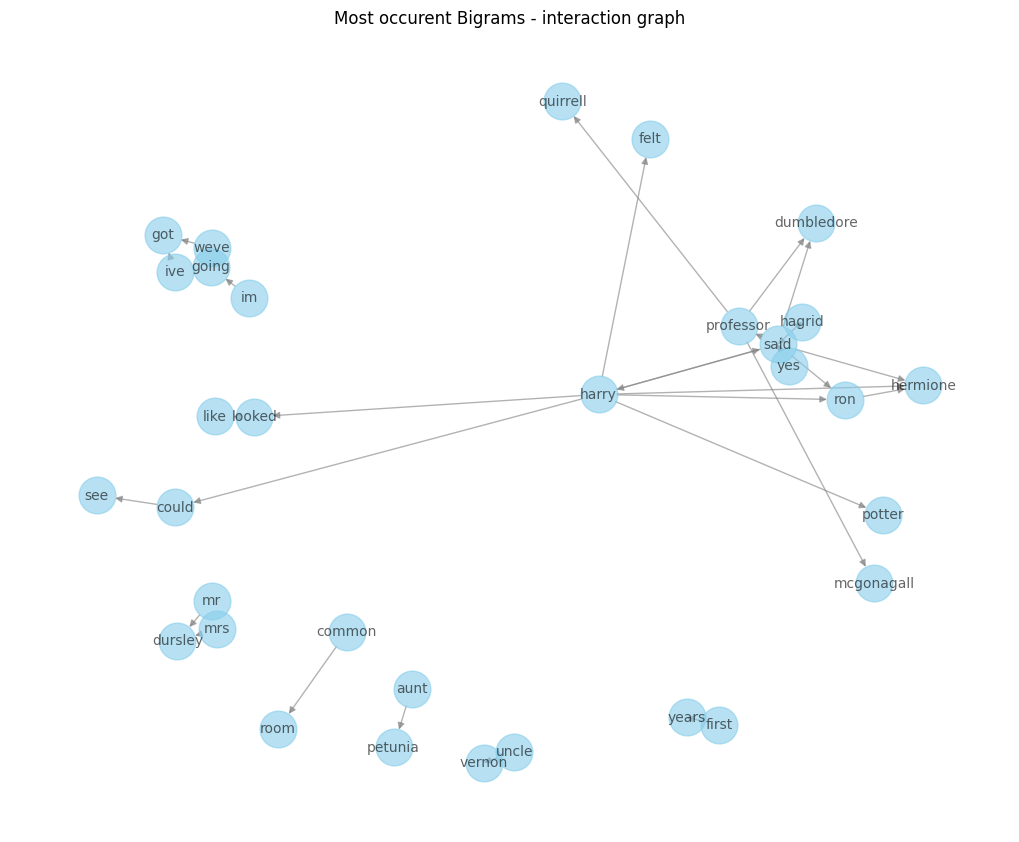

In [43]:
# plot graph 
plt.figure(figsize = (10,8))
pos = nx.spring_layout(G_bigrams_tfidf)
nx.draw(G_bigrams_tfidf,  pos = pos, with_labels=True, font_size=10, node_size=700, node_color='skyblue', edge_color='gray', alpha=0.6)
plt.title('Most occurent Bigrams - interaction graph')
plt.savefig('./images/eda/bigrams_graph_tfidf.png')
plt.show()

###  Gender Word Analysis (Emil Hvitfeld)

In the following we analyse the rank of gender and character specific words as well as considering sentiment analysis with a very simple approach. Therefore we take the function of eda_utils.py: get_gender_words() and get_character_words().

In [44]:
# get clean gender words from df
gender_words = df['clean_words_gender'].to_list()
gender_words = np.concatenate(gender_words)
count_dict = Counter(gender_words)
get_words = sorted(count_dict.keys(), key=lambda x: count_dict[x], reverse=True)

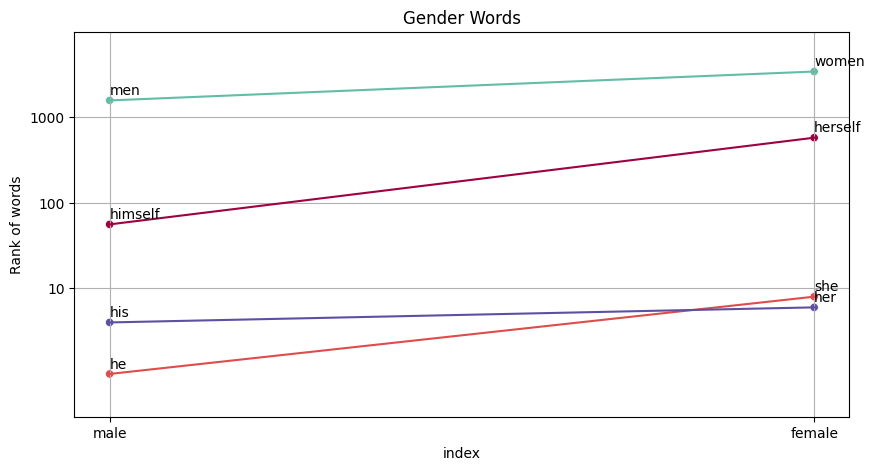

In [45]:
# word rank slope plot

# take function from eda_utils
gender_words = get_gender_words(get_words)
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=gender_words, x='index', y='rank', hue='rank_diff_log10', palette='Spectral', legend=False)
ax = sns.scatterplot(data=gender_words, x='index', y='rank', hue='rank_diff_log10', palette='Spectral', legend=False)
#ax.text(data=gender_words, x='index', y='rank', text='label', ha='center', va='bottom')
for i, true_label in enumerate(gender_words['label']):
    ax.annotate(true_label, (gender_words['index'][i] , gender_words['rank'][i] + 0.07), size = 10)
#plt.yscale('log')
plt.yticks(ticks=[1, 2, 3], labels=[10, 100, 1000])
plt.ylim([-0.5, 4])
#plt.xlim([-0.5, 1.5])
#plt.xlabel('')
plt.grid()
plt.ylabel('Rank of words')
plt.title('Gender Words')
plt.savefig('./images/eda/gender_words_all.png')
plt.show()

For a comparison over the series we compare the rank of gender words of HP1 and HP7.

In [46]:
# load HP1 and HP7 and get the clean_words_gender 

# HP1
book_1 = df[df['Book'] == 1]
gender_words_book_1 = book_1['clean_words_gender'].to_list()
gender_words_book_1 = np.concatenate(gender_words_book_1)
count_dict = Counter(gender_words_book_1)
get_words_book_1 = sorted(count_dict.keys(), key=lambda x: count_dict[x], reverse=True)

# HP7
book_7 = df[df['Book'] == 7]
gender_words_book_7 = book_7['clean_words_gender'].to_list()
gender_words_book_7 = np.concatenate(gender_words_book_7)
count_dict = Counter(gender_words_book_7)
get_words_book_7 = sorted(count_dict.keys(), key=lambda x: count_dict[x], reverse=True)

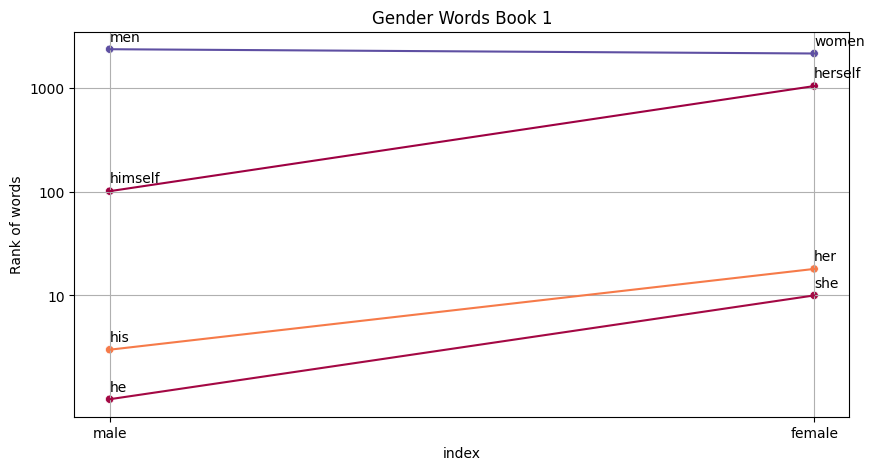

In [47]:
# word rank slope plot HP 1
gender_words = get_gender_words(get_words_book_1)
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=gender_words, x='index', y='rank', hue='rank_diff_log10', palette='Spectral', legend=False)
ax = sns.scatterplot(data=gender_words, x='index', y='rank', hue='rank_diff_log10', palette='Spectral', legend=False)
for i, true_label in enumerate(gender_words['label']):
    ax.annotate(true_label, (gender_words['index'][i] , gender_words['rank'][i] + 0.08), size = 10)
plt.yticks(ticks=[1, 2, 3], labels=[10, 100, 1000])
plt.grid()
plt.ylabel('Rank of words')
plt.title('Gender Words Book 1')
plt.savefig('./images/eda/gender_words_1.png')
plt.show()

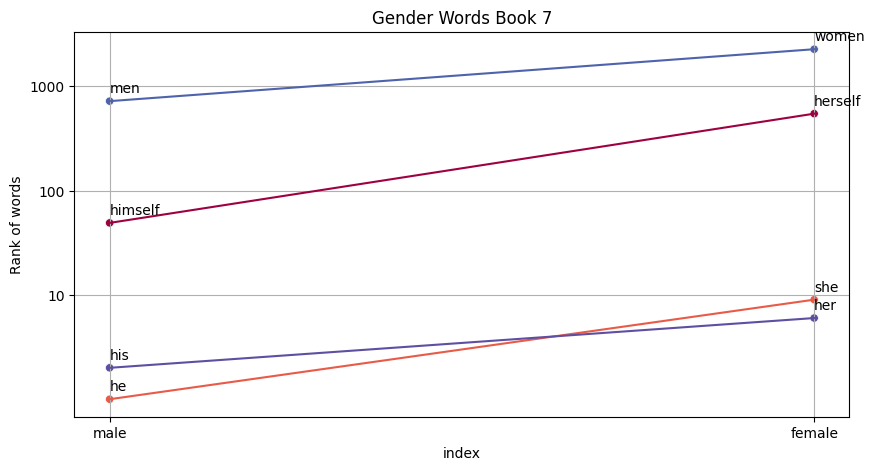

In [48]:
# word rank slope plot HP 7
gender_words = get_gender_words(get_words_book_7)
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=gender_words, x='index', y='rank', hue='rank_diff_log10', palette='Spectral', legend=False)
ax = sns.scatterplot(data=gender_words, x='index', y='rank', hue='rank_diff_log10', palette='Spectral', legend=False)
for i, true_label in enumerate(gender_words['label']):
    ax.annotate(true_label, (gender_words['index'][i] , gender_words['rank'][i] + 0.08), size = 10)
plt.yticks(ticks=[1, 2, 3], labels=[10, 100, 1000])
plt.grid()
plt.ylabel('Rank of words')
plt.title('Gender Words Book 7')
plt.savefig('./images/eda/gender_words_7.png')
plt.show()

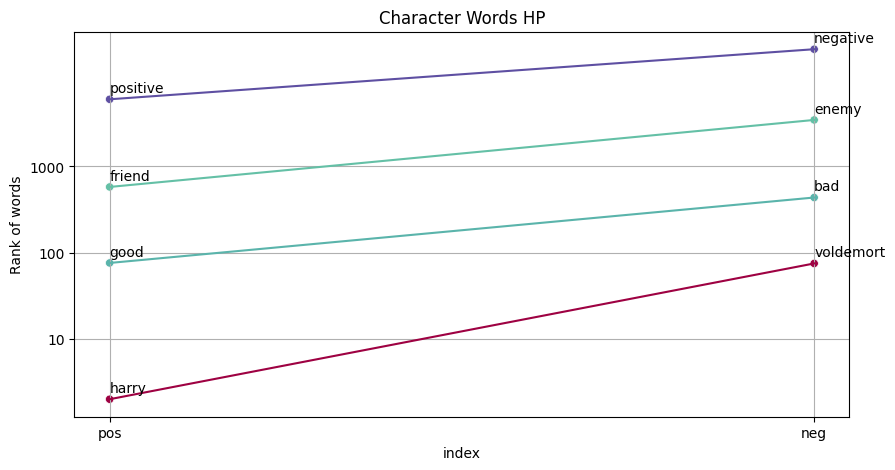

In [49]:
# word rank slope plot
character_words = get_character_words(get_words)
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=character_words, x='index', y='rank', hue='rank_diff_log10', palette='Spectral', legend=False)
ax = sns.scatterplot(data=character_words, x='index', y='rank', hue='rank_diff_log10', palette='Spectral', legend=False)
for i, true_label in enumerate(character_words['label']):
    ax.annotate(true_label, (character_words['index'][i] , character_words['rank'][i] + 0.08), size = 10)
plt.yticks(ticks=[1, 2, 3], labels=[10, 100, 1000])
plt.grid()
plt.ylabel('Rank of words')
plt.title('Character Words HP')
plt.savefig('./images/eda/character_words.png')
plt.show()

## Knowledge Graph with spaCy <a class="anchor" id="kg"></a>

A knowledge graph contains data points of entities which are connected by a relationship, which could represent a domain or a business f.e.. This sort of graphs can be built automatically. In this part of the project we will analyze the text dataset of the single books to get an initial idea, what happens. The knowledge graph is constructed with "entity 1" and "entity 2" and a relationship called "relation". For instance:

We will use the spaCy library for building a knowledge graph with en_core_web_sm including
https://spacy.io/models

In [50]:
# load nlp pipeline
nlp = spacy.load('en_core_web_sm')
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


To simulate a simple example we take a random sentence like: "Harry said, that he felt angry about Dudley. " and apply the nlp pipeline on it.

In [51]:
# simple example
example = nlp("Harry said, that he felt angry about Dudley. ")

print("Output of tagger:")
for tok in example:
    print(tok.text, "...", tok.dep_)

Output of tagger:
Harry ... nsubj
said ... ROOT
, ... punct
that ... mark
he ... nsubj
felt ... ccomp
angry ... acomp
about ... prep
Dudley ... pobj
. ... punct


In [52]:
# display the output
displacy.render(example, style="dep", jupyter=True)

In [53]:
# output of NER
print("Output of NER:")
for tok in example:
    print(tok.text, "...", tok.ent_type_)

Output of NER:
Harry ... PERSON
said ... 
, ... 
that ... 
he ... 
felt ... 
angry ... 
about ... 
Dudley ... PERSON
. ... 


In [54]:
displacy.render(example, style="ent", jupyter=True)

###  Knowledge Graph (general approach)

https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk

In this part we apply a general approach (copied from https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk) of building a knowledeg graph on the text corpus sentence_df with the Tagger pipeline of nlp. The functions are uploaded from kg_utils.py. The first one collect the entities and the second one the relations.

Let us test those functions on our simple example.

In [55]:
get_entities("Harry said, that he felt angry about Dudley. ", nlp)

('he', 'Dudley')

In [56]:
get_relation("Harry said, that he felt angry about Dudley. ", nlp)

'said'

In [57]:
# consider our sentence_df dataframe
sentence_df.head()

,Book,Chapter,sentence
0,1,1,the boy who lived mr and mrs dursley of numbe...
1,1,1,they were the last people youd expect to be in...
2,1,1,mr dursley was the director of a firm called g...
3,1,1,he was a big beefy man with hardly any neck al...
4,1,1,mrs dursley was thin and blonde and had nearly...


In [58]:
print(f'There are {len(sentence_df)} different sentences in the whole text corpus')

There are 70984 different sentences in the whole text corpus


We decided for a demonstration of the functionality of the general Knowledge Graph approach that we will consider the last book (HP 7).

In [59]:
# preprocess sentence dataframe
# only use sentences with specific length
sentence_df = create_sentence(df)
sentence_df = get_sentence_df(sentence_df)
sentence_df['length'] =  sentence_df['sentence'].apply(lambda x: len(x))
sentence_kg = sentence_df[sentence_df.length >50]
sentence_kg_7 = sentence_kg[sentence_kg['Book'] == 7]
sentence_kg_7 = sentence_kg_7.reset_index().drop(['index'], axis = 1)
sentence_kg_7.head(5)

,Book,Chapter,sentence,length
0,7,1,the two men appeared out of nowhere a few yard...,80
1,7,1,for a second they stood quite still wands dire...,364
2,7,1,the mens long cloaks flapped around their ankl...,203
3,7,1,you sound confident that your reception will b...,86
4,7,1,they turned right into a wide driveway that le...,60


In [60]:
print(f'There are {len(sentence_kg_7)} different sentences in HP 7 after cleaning and removing sentences with short length.')

There are 5835 different sentences in HP 7 after cleaning and removing sentences with short length.


In [61]:
# get entities of HP 7
entities_kg_7 = []
for i in tqdm(sentence_kg_7['sentence']):
    entities_kg_7.append(get_entities(i, nlp))

100%|██████████| 5835/5835 [01:29<00:00, 64.94it/s]


In [62]:
# get relations of HP 7
relation = [get_relation(i, nlp) for i in tqdm(sentence_kg_7['sentence'])]

100%|██████████| 5835/5835 [01:29<00:00, 65.05it/s]


In [63]:
# get subject
source = [i[0] for i in entities_kg_7]
# get object
target = [i[1] for i in entities_kg_7 ]
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

In [64]:
kg_df.head(3)

,source,target,edge
0,two men,narrow moonlit lane,appeared out
1,then they,manicured lowgrowing hedge,stood
2,branches,overhanging moonlight,said


In [65]:
kg_df.edge.value_counts()[:10]

edge
said       566
was        295
is         105
think      102
had         69
know        68
looked      66
thought     61
seemed      60
were        56
Name: count, dtype: int64

Assume now that Harry is the source of everything.

In [66]:
# kg_df with source Harry in HP 7
kg_df_harry = kg_df[kg_df['source']== "harry"]
len(kg_df_harry)

130

In [67]:
# create knowledge Graph from kg dataframe
G = nx.DiGraph()
for _, row in  kg_df_harry[:50].iterrows():
    G.add_edge(row['source'], row['target'], label=row['edge'])

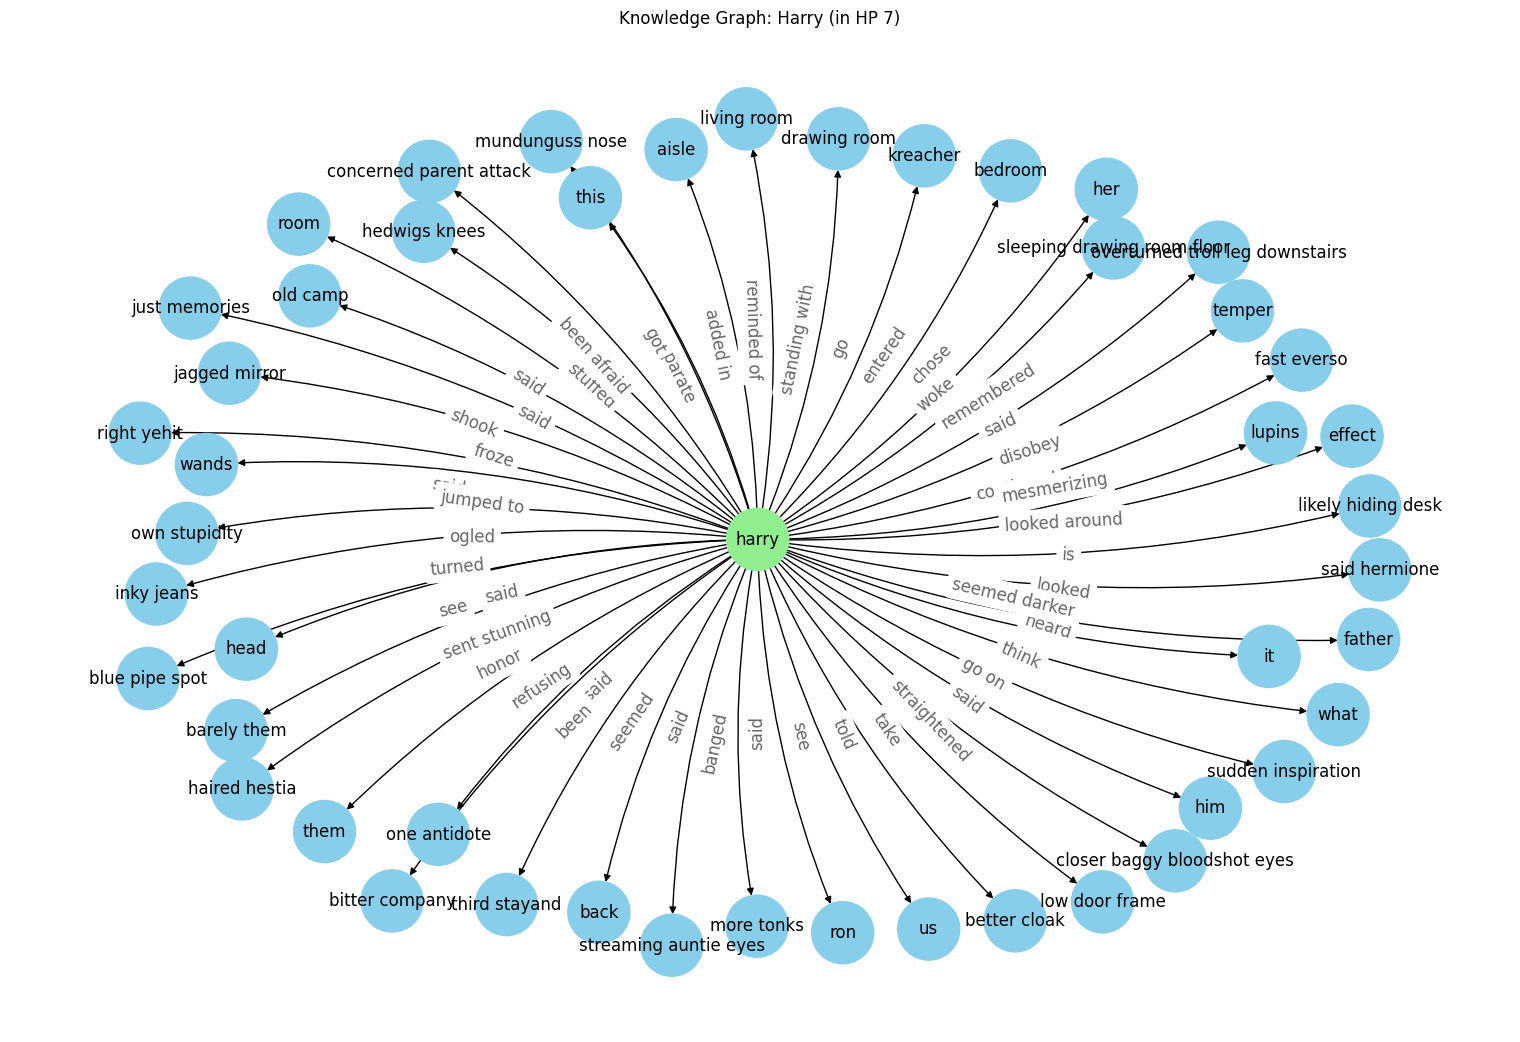

In [68]:
plt.figure(figsize=(15,10))
pos = nx.spring_layout(G, k=2)
labels = nx.get_edge_attributes(G, 'label')
node_color = ["lightgreen" if node=="harry" else "skyblue" for node in G.nodes]
nx.draw(G, pos=pos, with_labels=True, node_color=node_color, edge_color="black", cmap=plt.cm.Dark2, node_size=2000, node_shape="o", connectionstyle='arc3,rad=0.1')
nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, edge_labels=labels,font_size=12, font_color='black', alpha=0.6)
plt.title('Knowledge Graph: Harry (in HP 7)')
plt.savefig('./images/knowledge_graph/book7_harry.png')
plt.show()

Assume now the same for Voldmort.

In [69]:
# kg_df with source voldemort in HP 7
kg_df_vold = kg_df[(kg_df['source']== "voldemort")| (kg_df["target"]=="voldemort")]
len(kg_df_vold)

29

In [70]:
kg_df_vold.head(3)

,source,target,edge
38,voldemort,twisted backit,have
61,malfoyand ¨c dragon heartstringgood,voldemort,put
85,first it,voldemort,have


In [71]:
# create knowledge Graph from kg dataframe
G_voldemort = nx.DiGraph()
for _, row in  kg_df_vold.iterrows():
    G_voldemort.add_edge(row['source'], row['target'], label=row['edge'])

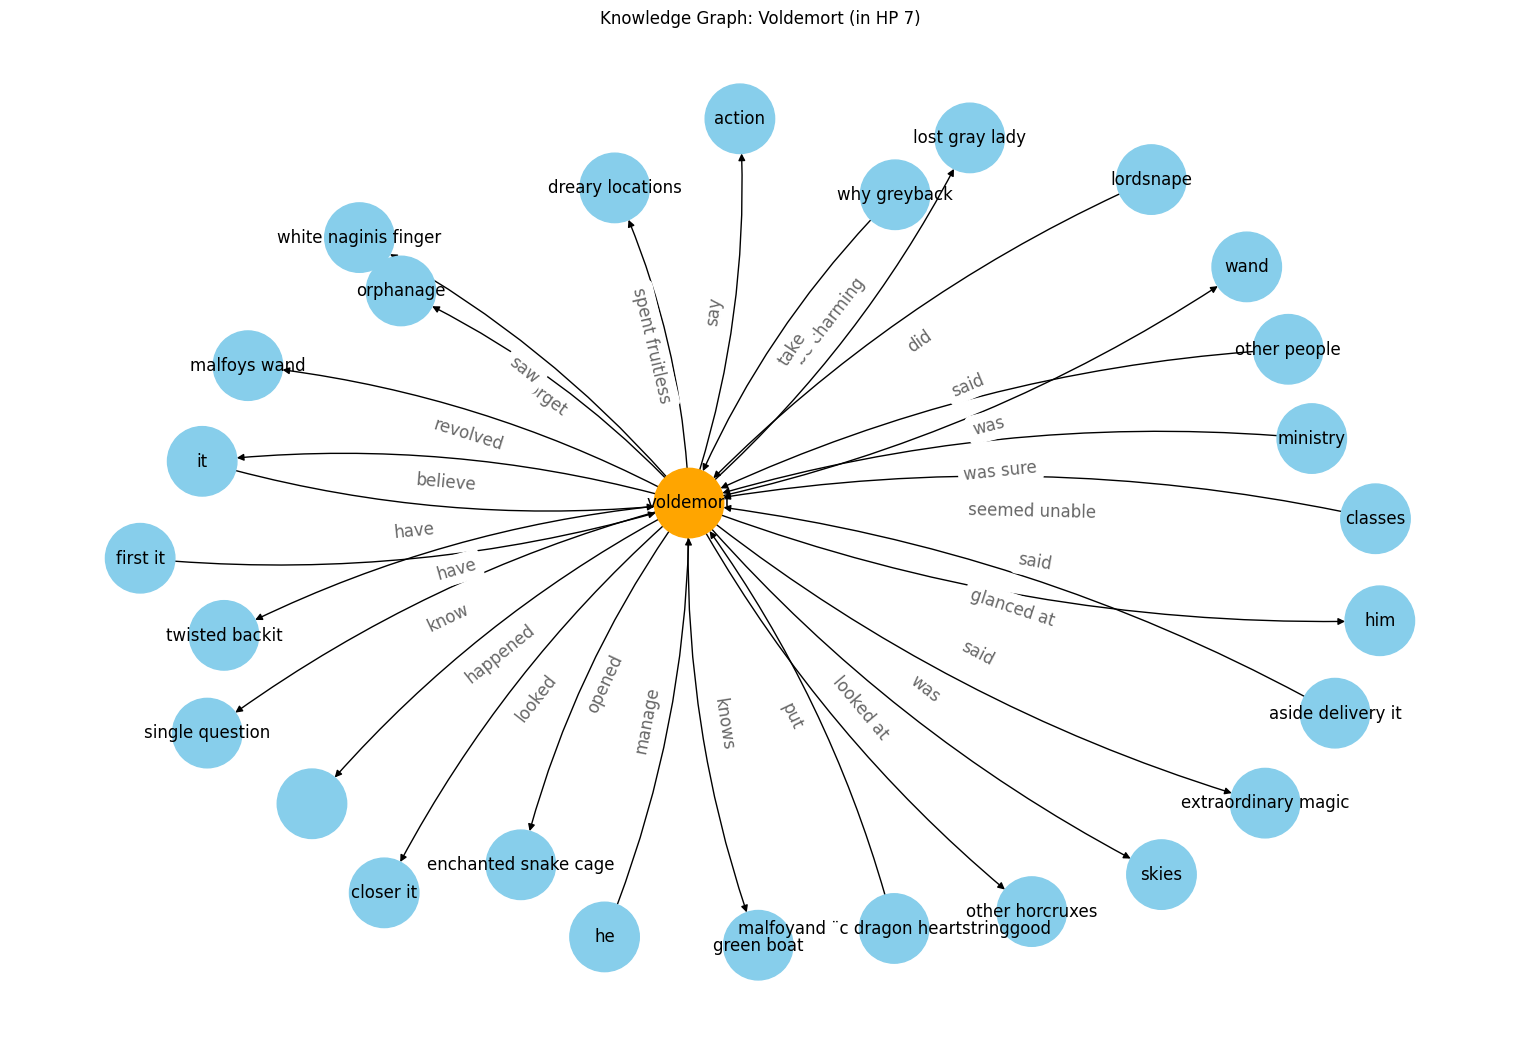

In [72]:
# plot knowledge graph
plt.figure(figsize=(15,10))
# define pos and labels of the edges
pos = nx.spring_layout(G_voldemort, k=2)
labels = nx.get_edge_attributes(G_voldemort, 'label')

# define node color
node_color = ["orange" if node=="voldemort" else "skyblue" for node in G_voldemort.nodes]

# draw graphs
nx.draw(G_voldemort, pos=pos, with_labels=True, node_color=node_color, edge_color="black", cmap=plt.cm.Dark2, node_size=2500, node_shape="o", connectionstyle='arc3,rad=0.1')
nx.draw_networkx_edge_labels(G_voldemort, pos=pos, label_pos=0.5, edge_labels=labels,font_size=12, font_color='black', alpha=0.6)
plt.title('Knowledge Graph: Voldemort (in HP 7)')
plt.savefig('./images/knowledge_graph/book7_vold.png')
plt.show()

### Knowledge Graph with Textacy

We decided to use a different approach with textacy, which is a library of spacy, which automatically detect the triple, subject, object, verb. We consider again only HP7.

In [73]:
# apply nlp on the sentence_kg_7
doc = [nlp(i) for i in tqdm(sentence_kg_7['sentence'])]
# print simple example
i = 2
print(doc[i])

100%|██████████| 5835/5835 [01:24<00:00, 68.94it/s]

the mens long cloaks flapped around their ankles as they marchedthought i might be late said yaxley his blunt features sliding in and out of sight as the branches of overhanging trees broke the moonlight


In [74]:
# get subject, object, verb triple
values = {"id":[], "text":[], "subject":[], "verb":[], "object":[]}
for n,sentence in enumerate(doc):
    doc_gen = list(textacy.extract.subject_verb_object_triples(sentence))  
    for sent in doc_gen:
        subj = "_".join(map(str, sent.subject))
        obj  = "_".join(map(str, sent.object))
        verb = "_".join(map(str, sent.verb))
        values["id"].append(n)
        values["text"].append(sentence.text)
        values["subject"].append(subj)
        values["object"].append(obj)
        values["verb"].append(verb)
kg_df = pd.DataFrame(values)

In [75]:
kg_df.head(5)

,id,text,subject,verb,object
0,1,for a second they stood quite still wands dire...,they,stood,chests
1,1,for a second they stood quite still wands dire...,they,stowed,wands
2,1,for a second they stood quite still wands dire...,they,started,walking_briskly_in_the_same_directionnews
3,1,for a second they stood quite still wands dire...,they,was_bordered,lowgrowing_brambles_hedge
4,2,the mens long cloaks flapped around their ankl...,branches,broke,moonlight


#### Count the relation between the sentiments of the sentence and the characters

Analyse the sentiment of the sentences with Vader.

In [76]:
# apply sentiment analysis
analyzer = SentimentIntensityAnalyzer()
compound_sentence = [analyzer.polarity_scores(str(x))['compound'] for x in kg_df['text']]

In [77]:
# create column with compounds values
kg_df['sentiment'] = pd.Series(compound_sentence)
kg_df.head(3)

,id,text,subject,verb,object,sentiment
0,1,for a second they stood quite still wands dire...,they,stood,chests,0.765
1,1,for a second they stood quite still wands dire...,they,stowed,wands,0.765
2,1,for a second they stood quite still wands dire...,they,started,walking_briskly_in_the_same_directionnews,0.765


#### Count the relation between the sentiments of the sentence and the characters

In [78]:
# define labels related to compound value
label = []
for i in range(len(kg_df)):
    if kg_df['sentiment'][i]>=0.05:
        label.append(1)
    elif kg_df['sentiment'][i]<=-0.05:
        label.append(-1)
    else:
        label.append(0)

In [79]:
# set label column
kg_df['label'] = pd.Series(label)
kg_df.head(3)

,id,text,subject,verb,object,sentiment,label
0,1,for a second they stood quite still wands dire...,they,stood,chests,0.765,1
1,1,for a second they stood quite still wands dire...,they,stowed,wands,0.765,1
2,1,for a second they stood quite still wands dire...,they,started,walking_briskly_in_the_same_directionnews,0.765,1


In [80]:
# count the percentage of positive and negative sentences with subject or object "harry"
kg_df_filter_harry= kg_df[(kg_df["subject"]=="harry") |(kg_df["object"]=="harry")]
kg_df_filter_harry_pos = kg_df_filter_harry[kg_df_filter_harry['label']==1]
kg_df_filter_harry_neg = kg_df_filter_harry[kg_df_filter_harry['label']==-1]
kg_df_filter_harry_neut = kg_df_filter_harry[kg_df_filter_harry['label']==0]
print(f'The number of sentences related  to harry which are positive are {np.round((len(kg_df_filter_harry_pos)/len(kg_df_filter_harry))*100,2)} %')
print(f'The number of sentences related to harry which are negative are {np.round((len(kg_df_filter_harry_neg)/len(kg_df_filter_harry))*100,2)} %')
print(f'The number of sentences related  to harry which are neutral are {np.round((len(kg_df_filter_harry_neut)/len(kg_df_filter_harry))*100,2)} %')

The number of sentences related  to harry which are positive are 32.35 %
The number of sentences related to harry which are negative are 49.07 %
The number of sentences related  to harry which are neutral are 18.58 %


In [81]:
# count the percentage of positive and negative sentences with subject or object "voldemort"
kg_df_filter_vold= kg_df[(kg_df["subject"]=="voldemort") |(kg_df["object"]=="voldemort")]
kg_df_filter_vold_pos = kg_df_filter_vold[kg_df_filter_vold['label']==1]
kg_df_filter_vold_neg = kg_df_filter_vold[kg_df_filter_vold['label']==-1]
kg_df_filter_vold_neut = kg_df_filter_vold[kg_df_filter_vold['label']==0]
print(f'The percentage of sentences related to voldemort which are positive are {np.round((len(kg_df_filter_vold_pos)/len(kg_df_filter_vold))*100,2)} %')
print(f'The percentage of sentences related to voldemort which are negative are {np.round((len(kg_df_filter_vold_neg)/len(kg_df_filter_vold))*100,2)} %')
print(f'The percentage of sentences related to voldemort which are neutral are {np.round((len(kg_df_filter_vold_neut)/len(kg_df_filter_vold))*100,2)} %')

The percentage of sentences related to voldemort which are positive are 33.72 %
The percentage of sentences related to voldemort which are negative are 52.33 %
The percentage of sentences related to voldemort which are neutral are 13.95 %


This is a more reasonable result for a knowledge graph in terms of giving a content summary, but let us therefore consider graph visualizations.

In [82]:
# only select the negative sentences to build the graph
G_filter_vold_neg = nx.from_pandas_edgelist(kg_df_filter_vold_neg, source="subject", target="object", edge_attr="verb", create_using=nx.DiGraph())

In [83]:
kg_df_filter_vold.head(3)

,id,text,subject,verb,object,sentiment,label
19,24,most of the eyes around the table followed sna...,voldemort,spoke,firstsomy_lord,0.7003,1
59,50,voldemort however seemed to be speaking more t...,voldemort,seemed,to_be_speaking_more_to_himself_than_to_any_of_...,0.1451,1
61,50,voldemort however seemed to be speaking more t...,voldemort,have_been_thwarted,luck,0.1451,1


In [84]:
kg_df_filter_vold.verb.value_counts()[:10]

verb
said             6
sought           4
seemed           2
asked            2
spoke            1
murmured         1
swept            1
had_managed      1
shouted          1
had_stationed    1
Name: count, dtype: int64

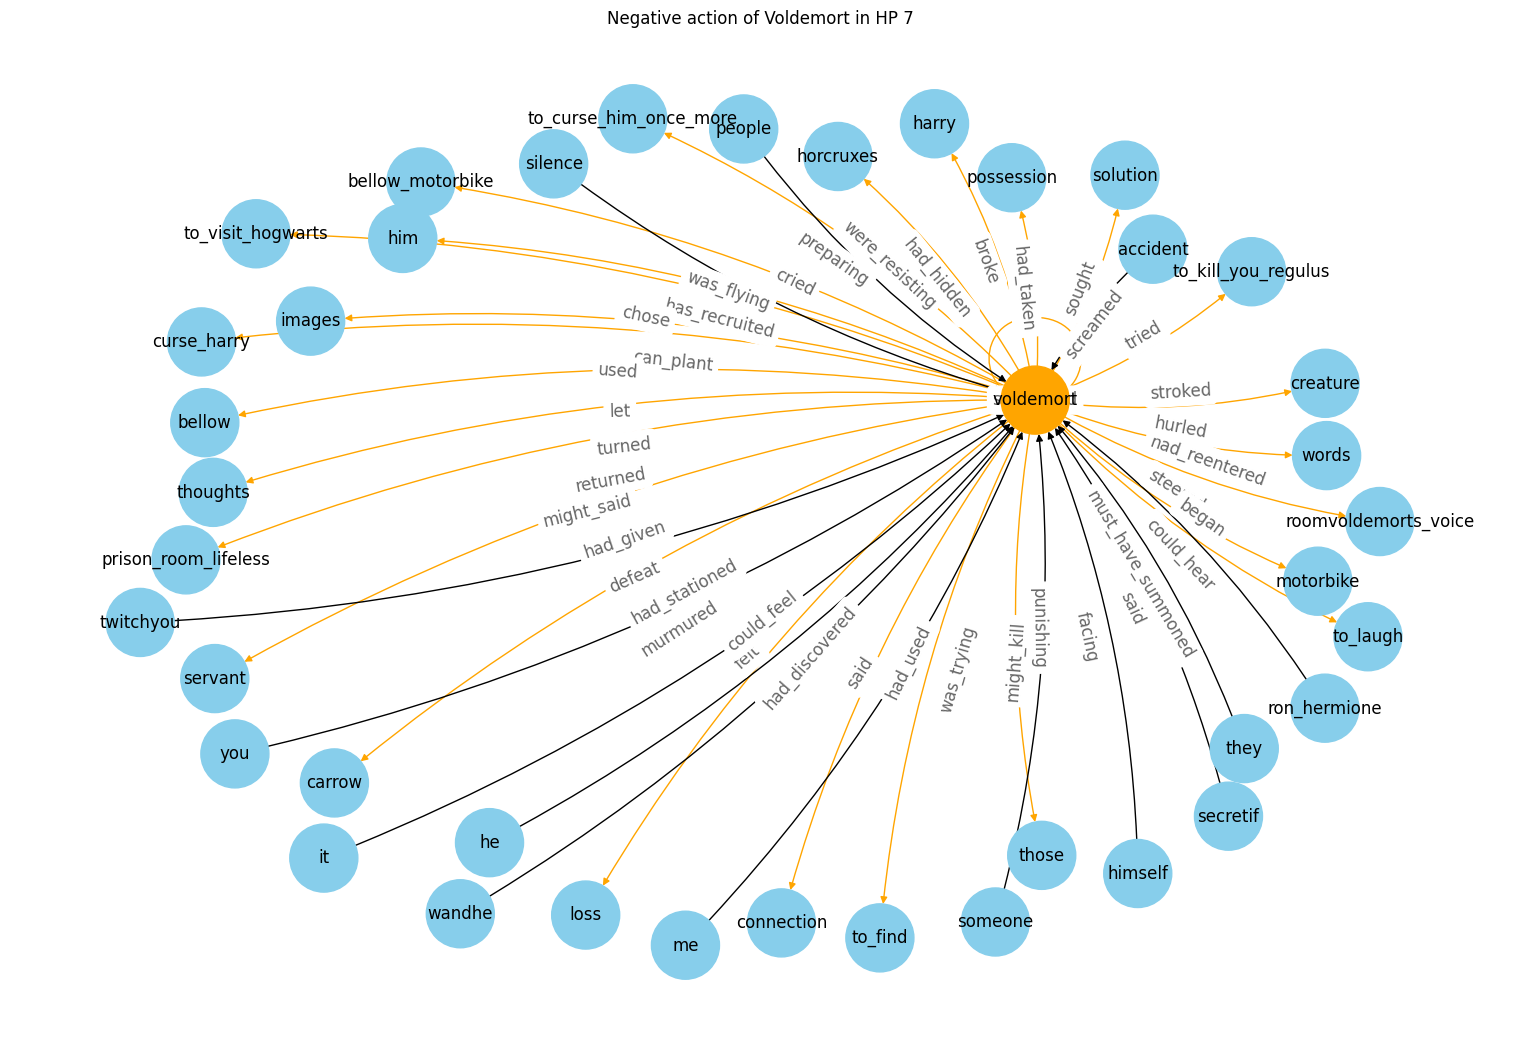

In [85]:
# plot the negative action of Voldemort in HP 7
plt.figure(figsize=(15,10))
# define pos
pos = nx.spring_layout(G_filter_vold_neg, k =2.5)
edge_labels = nx.get_edge_attributes(G_filter_vold_neg, 'verb')
# define color of nodes and edges
node_color = ["orange" if node=="voldemort" else "skyblue" for node in G_filter_vold_neg.nodes]
edge_color = ["orange" if edge[0]=="voldemort" else "black" for edge in G_filter_vold_neg.edges]

nx.draw(G_filter_vold_neg, pos=pos, with_labels=True, node_color=node_color, edge_color = edge_color ,cmap=plt.cm.Dark2, node_size=2400, node_shape="o", connectionstyle='arc3,rad=0.1')
nx.draw_networkx_edge_labels(G_filter_vold_neg, pos=pos, label_pos=0.5, edge_labels=edge_labels,font_size=12, font_color='black', alpha=0.6)
plt.title('Negative action of Voldemort in HP 7')
plt.savefig('./images/knowledge_graph/book7_vold_textacy.png')
plt.show()

With knowledge graph one can get an inital summary about the content of each book and how the characters are related. To get an idea of how the characters are related we will build a social network in the following part of this project. It must be noted that this is already done in a similar way by https://github.com/thu-vu92/the_witcher_network, which result we will compare with a different approach.

In [86]:
print(f"The notebook runtime is : {time.time() - start_time:.3f}s")

The notebook runtime is : 355.855s
